# 训练损失可视化

该脚本用于绘制训练和验证损失曲线，帮助分析模型训练过程。

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 设置matplotlib参数，避免中文显示问题
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [58]:
# 配置文件路径
metrics_path = "/home/ma-user/work/mincycle4csp/outputs/crystal_transformer_cfm_cfg_20250829_023539/logs/metrics/metrics.csv"

# 读取CSV文件
print(f"Reading metrics from: {metrics_path}")
df = pd.read_csv(metrics_path)

print(f"Data shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Reading metrics from: /home/ma-user/work/mincycle4csp/outputs/crystal_transformer_cfm_cfg_20250829_023539/logs/metrics/metrics.csv
Data shape: (1089, 38)

Columns: ['epoch', 'lr-AdamW', 'step', 'train/coords_loss', 'train/lattice_angles_loss', 'train/lattice_invariant_loss', 'train/lattice_lengths_loss', 'train/lattice_loss', 'train/lattice_total_invariant', 'train/lattice_velocity_loss', 'train/lattice_volume_loss', 'train/loss_epoch', 'train/loss_step', 'train/lr', 'train/original_loss', 'train/relative_error', 'train/sigma_mean', 'train/t_mean', 'train/v_pred_norm', 'train/v_target_norm', 'val/coords_in_range', 'val/coords_loss', 'val/generated_volume', 'val/lattice_angles_loss', 'val/lattice_invariant_loss', 'val/lattice_lengths_loss', 'val/lattice_loss', 'val/lattice_total_invariant', 'val/lattice_velocity_loss', 'val/lattice_volume_loss', 'val/loss', 'val/original_loss', 'val/relative_error', 'val/sample_mse', 'val/sigma_mean', 'val/t_mean', 'val/v_pred_norm', 'val/v_target_norm'

In [59]:
# 数据预处理：过滤有效数据
# 训练数据：epoch不为空且有train/loss_step数据
train_data = df[(df['epoch'].notna()) & (df['train/loss_step'].notna())].copy()

# 验证数据：有val/loss数据
val_data = df[df['val/loss'].notna()].copy()

print(f"Training steps: {len(train_data)}")
print(f"Validation steps: {len(val_data)}")

if len(train_data) > 0:
    print(f"Training loss range: {train_data['train/loss_step'].min():.4f} - {train_data['train/loss_step'].max():.4f}")
if len(val_data) > 0:
    print(f"Validation loss range: {val_data['val/loss'].min():.4f} - {val_data['val/loss'].max():.4f}")

Training steps: 349
Validation steps: 30
Training loss range: 1.8471 - 7.5302
Validation loss range: 2.6581 - 3.3336


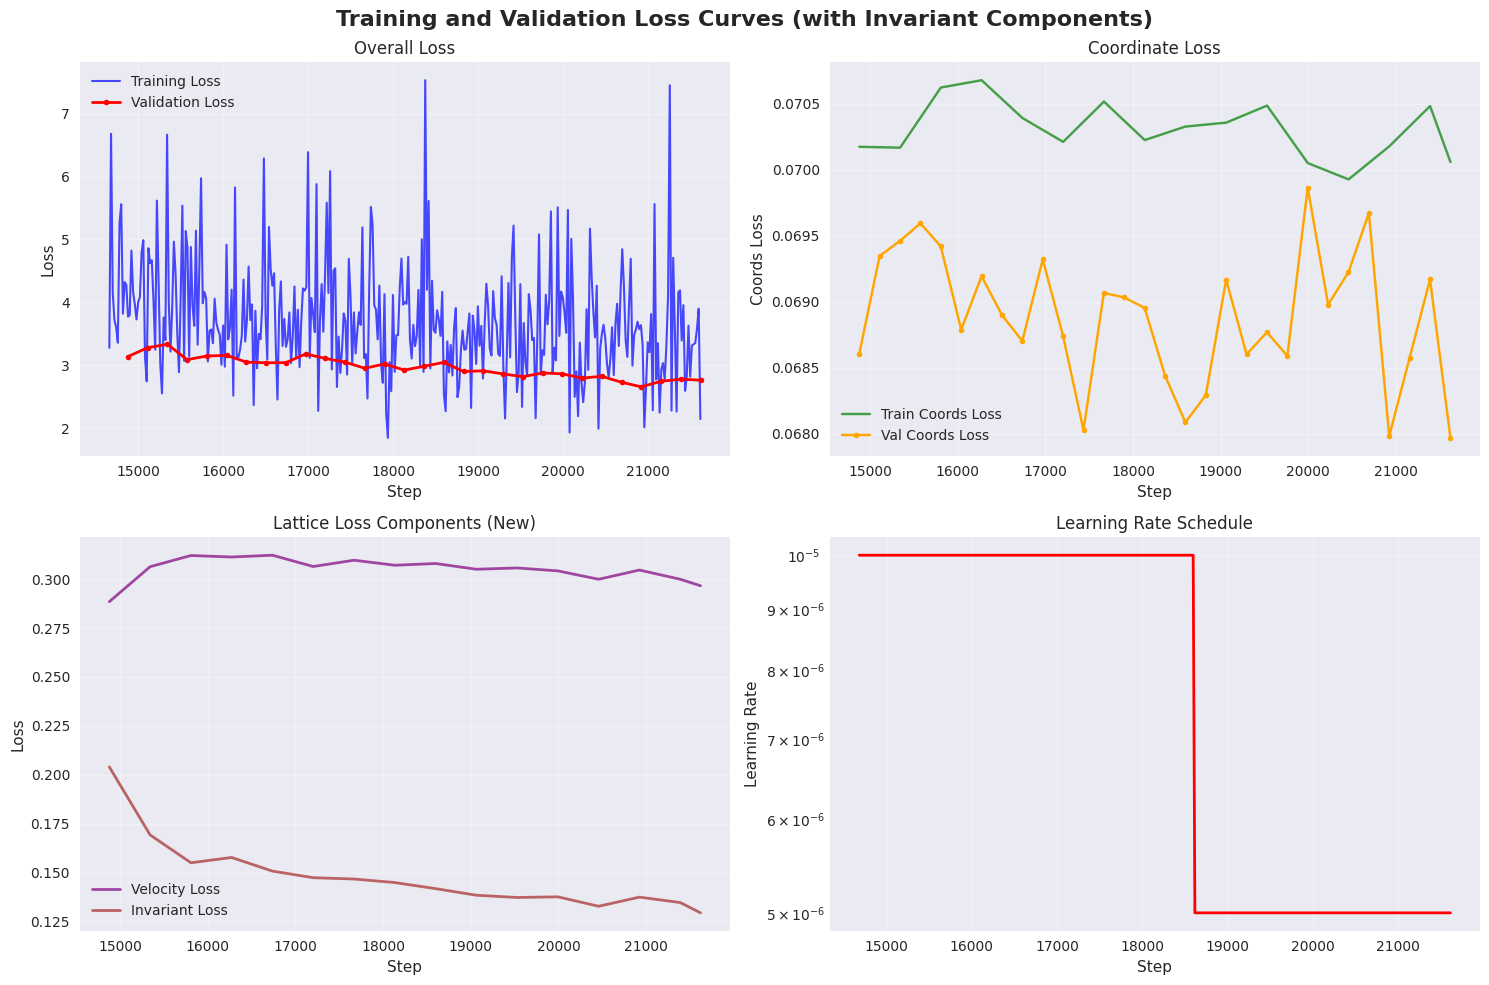

In [60]:
# 创建损失曲线图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training and Validation Loss Curves (with Invariant Components)', fontsize=16, fontweight='bold')

# 1. 总体损失曲线
ax1 = axes[0, 0]
if len(train_data) > 0:
    ax1.plot(train_data['step'], train_data['train/loss_step'], 
             label='Training Loss', color='blue', alpha=0.7, linewidth=1.5)
if len(val_data) > 0:
    ax1.plot(val_data['step'], val_data['val/loss'], 
             label='Validation Loss', color='red', marker='o', markersize=4, linewidth=2)

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Overall Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 坐标损失 (coords_loss)
ax2 = axes[0, 1]
train_coords = df[(df['train/coords_loss'].notna())]
val_coords = df[(df['val/coords_loss'].notna())]

if len(train_coords) > 0:
    ax2.plot(train_coords['step'], train_coords['train/coords_loss'], 
             label='Train Coords Loss', color='green', alpha=0.7)
if len(val_coords) > 0:
    ax2.plot(val_coords['step'], val_coords['val/coords_loss'], 
             label='Val Coords Loss', color='orange', marker='o', markersize=4)

ax2.set_xlabel('Step')
ax2.set_ylabel('Coords Loss')
ax2.set_title('Coordinate Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 晶格损失分解 (velocity vs invariant) - 支持新旧格式
ax3 = axes[1, 0]
# 尝试新格式的分解损失
train_lattice_vel = df[(df['train/lattice_velocity_loss'].notna())]
train_lattice_inv = df[(df['train/lattice_invariant_loss'].notna())]

if len(train_lattice_vel) > 0 and len(train_lattice_inv) > 0:
    # 新格式：显示分解的晶格损失
    ax3.plot(train_lattice_vel['step'], train_lattice_vel['train/lattice_velocity_loss'], 
             label='Velocity Loss', color='purple', alpha=0.7, linewidth=2)
    ax3.plot(train_lattice_inv['step'], train_lattice_inv['train/lattice_invariant_loss'], 
             label='Invariant Loss', color='brown', alpha=0.7, linewidth=2)
    ax3.set_title('Lattice Loss Components (New)')
else:
    # 旧格式：显示总的晶格损失
    train_lattice = df[(df['train/lattice_loss'].notna())]
    val_lattice = df[(df['val/lattice_loss'].notna())]
    
    if len(train_lattice) > 0:
        ax3.plot(train_lattice['step'], train_lattice['train/lattice_loss'], 
                 label='Train Lattice Loss', color='purple', alpha=0.7)
    if len(val_lattice) > 0:
        ax3.plot(val_lattice['step'], val_lattice['val/lattice_loss'], 
                 label='Val Lattice Loss', color='brown', marker='o', markersize=4)
    ax3.set_title('Lattice Loss (Legacy)')

ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 学习率曲线
ax4 = axes[1, 1]
lr_data = df[df['train/lr'].notna()]
if len(lr_data) > 0:
    ax4.plot(lr_data['step'], lr_data['train/lr'], 
             label='Learning Rate', color='red', linewidth=2)
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Learning Rate')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Learning Rate Data', 
             horizontalalignment='center', verticalalignment='center', 
             transform=ax4.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

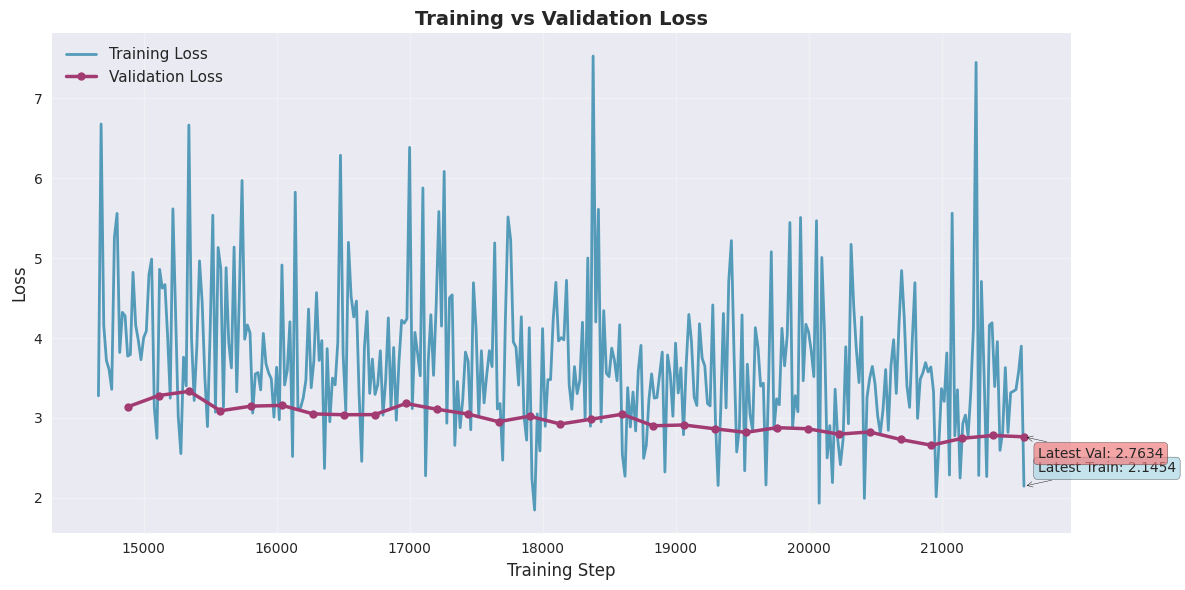

In [61]:
# 创建单独的损失对比图
plt.figure(figsize=(12, 6))

# 绘制训练和验证损失的对比
if len(train_data) > 0:
    plt.plot(train_data['step'], train_data['train/loss_step'], 
             label='Training Loss', color='#2E86AB', linewidth=2, alpha=0.8)

if len(val_data) > 0:
    plt.plot(val_data['step'], val_data['val/loss'], 
             label='Validation Loss', color='#A23B72', 
             marker='o', markersize=6, linewidth=2.5)

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 添加最新损失值注释
if len(train_data) > 0:
    latest_train_loss = train_data['train/loss_step'].iloc[-1]
    latest_train_step = train_data['step'].iloc[-1]
    plt.annotate(f'Latest Train: {latest_train_loss:.4f}', 
                xy=(latest_train_step, latest_train_loss), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

if len(val_data) > 0:
    latest_val_loss = val_data['val/loss'].iloc[-1]
    latest_val_step = val_data['step'].iloc[-1]
    plt.annotate(f'Latest Val: {latest_val_loss:.4f}', 
                xy=(latest_val_step, latest_val_loss), 
                xytext=(10, -15), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

In [62]:
# 训练统计信息
print("=== Training Statistics ===")
if len(train_data) > 0:
    print(f"Total training steps: {len(train_data)}")
    print(f"Training loss - Min: {train_data['train/loss_step'].min():.6f}")
    print(f"Training loss - Max: {train_data['train/loss_step'].max():.6f}")
    print(f"Training loss - Final: {train_data['train/loss_step'].iloc[-1]:.6f}")
    print(f"Training loss - Mean: {train_data['train/loss_step'].mean():.6f}")

print("\n=== Validation Statistics ===")
if len(val_data) > 0:
    print(f"Total validation steps: {len(val_data)}")
    print(f"Validation loss - Min: {val_data['val/loss'].min():.6f}")
    print(f"Validation loss - Max: {val_data['val/loss'].max():.6f}")
    print(f"Validation loss - Final: {val_data['val/loss'].iloc[-1]:.6f}")
    print(f"Validation loss - Mean: {val_data['val/loss'].mean():.6f}")

# 检查是否存在过拟合趋势
if len(train_data) > 0 and len(val_data) > 0:
    print("\n=== Overfitting Analysis ===")
    final_train_loss = train_data['train/loss_step'].iloc[-1]
    final_val_loss = val_data['val/loss'].iloc[-1]
    gap = final_val_loss - final_train_loss
    print(f"Final loss gap (val - train): {gap:.6f}")
    if gap > 0.5:
        print("⚠️  Warning: Large validation-training gap suggests possible overfitting")
    elif gap < 0:
        print("ℹ️  Info: Validation loss lower than training loss (normal in some cases)")
    else:
        print("✅ Good: Reasonable validation-training gap")

=== Training Statistics ===
Total training steps: 349
Training loss - Min: 1.847092
Training loss - Max: 7.530161
Training loss - Final: 2.145372
Training loss - Mean: 3.719014

=== Validation Statistics ===
Total validation steps: 30
Validation loss - Min: 2.658106
Validation loss - Max: 3.333594
Validation loss - Final: 2.763429
Validation loss - Mean: 2.969423

=== Overfitting Analysis ===
Final loss gap (val - train): 0.618057
⚠️  Warning: Large validation-training gap suggests possible overfitting


Loss curve saved to: /home/ma-user/work/mincycle4csp/scripts/plots/loss_curves.png


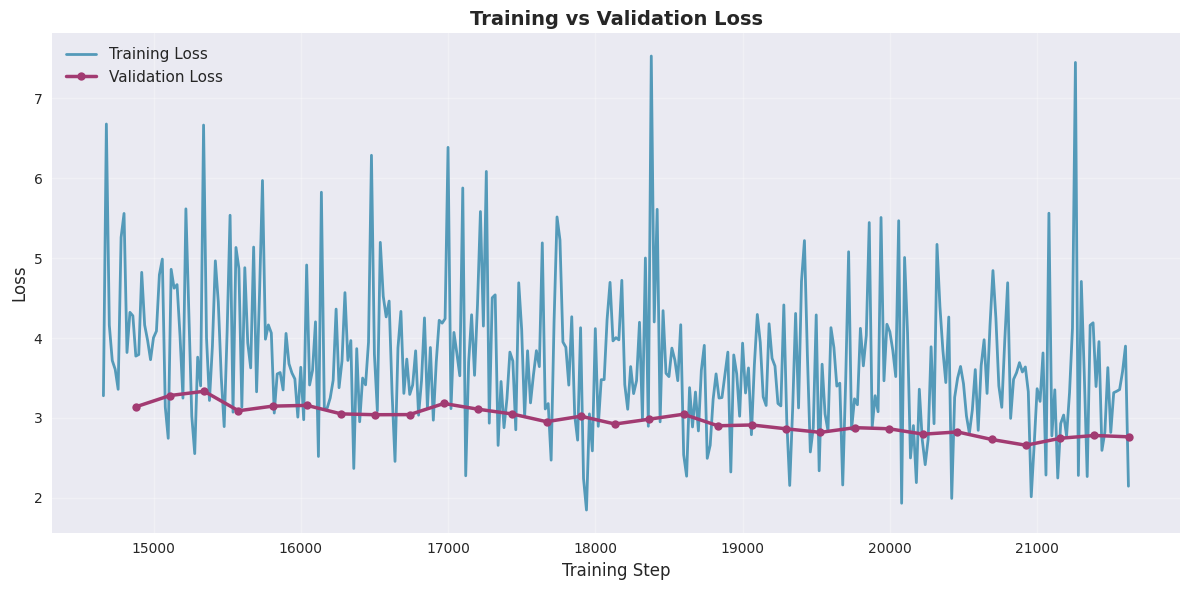

In [63]:
# 可选：保存图片
save_plots = True  # 设置为True以保存图片

if save_plots:
    output_dir = Path("/home/ma-user/work/mincycle4csp/scripts/plots")
    output_dir.mkdir(exist_ok=True)
    
    # 重新生成并保存主要的损失对比图
    plt.figure(figsize=(12, 6))
    
    if len(train_data) > 0:
        plt.plot(train_data['step'], train_data['train/loss_step'], 
                 label='Training Loss', color='#2E86AB', linewidth=2, alpha=0.8)
    
    if len(val_data) > 0:
        plt.plot(val_data['step'], val_data['val/loss'], 
                 label='Validation Loss', color='#A23B72', 
                 marker='o', markersize=6, linewidth=2.5)
    
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plot_path = output_dir / "loss_curves.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Loss curve saved to: {plot_path}")
    plt.show()

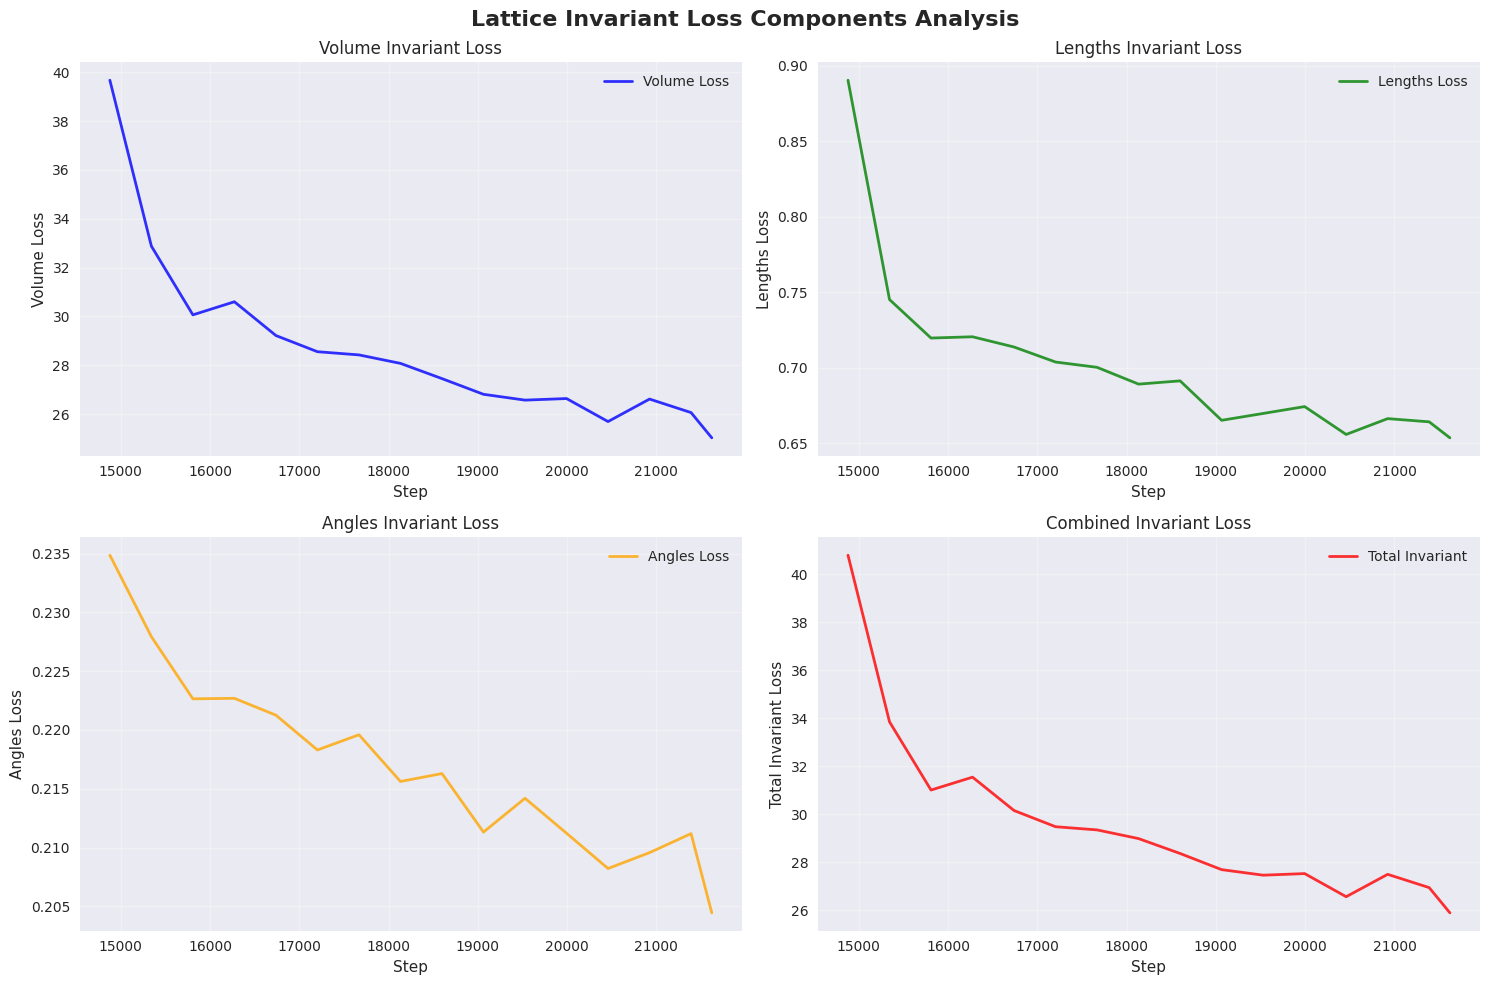

=== Invariant Loss Statistics ===
train/lattice_volume_loss: 25.026190 - 39.675114 (final: 25.026190)
train/lattice_lengths_loss: 0.653742 - 0.890313 (final: 0.653742)
train/lattice_angles_loss: 0.204452 - 0.234861 (final: 0.204452)
train/lattice_total_invariant: 25.884377 - 40.800301 (final: 25.884377)


In [64]:
# 等变性不变量损失详细分析 (新功能)
invariant_columns = ['train/lattice_volume_loss', 'train/lattice_lengths_loss', 
                    'train/lattice_angles_loss', 'train/lattice_total_invariant']

# 检查是否有不变量损失数据
has_invariant_data = any(col in df.columns and df[col].notna().any() for col in invariant_columns)

if has_invariant_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Lattice Invariant Loss Components Analysis', fontsize=16, fontweight='bold')
    
    # 1. 体积损失
    ax1 = axes[0, 0]
    if 'train/lattice_volume_loss' in df.columns:
        vol_data = df[df['train/lattice_volume_loss'].notna()]
        if len(vol_data) > 0:
            ax1.plot(vol_data['step'], vol_data['train/lattice_volume_loss'], 
                     color='blue', linewidth=2, alpha=0.8, label='Volume Loss')
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Volume Loss')
            ax1.set_title('Volume Invariant Loss')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
    
    # 2. 边长损失
    ax2 = axes[0, 1]
    if 'train/lattice_lengths_loss' in df.columns:
        lengths_data = df[df['train/lattice_lengths_loss'].notna()]
        if len(lengths_data) > 0:
            ax2.plot(lengths_data['step'], lengths_data['train/lattice_lengths_loss'], 
                     color='green', linewidth=2, alpha=0.8, label='Lengths Loss')
            ax2.set_xlabel('Step')
            ax2.set_ylabel('Lengths Loss')
            ax2.set_title('Lengths Invariant Loss')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
    
    # 3. 角度损失
    ax3 = axes[1, 0]
    if 'train/lattice_angles_loss' in df.columns:
        angles_data = df[df['train/lattice_angles_loss'].notna()]
        if len(angles_data) > 0:
            ax3.plot(angles_data['step'], angles_data['train/lattice_angles_loss'], 
                     color='orange', linewidth=2, alpha=0.8, label='Angles Loss')
            ax3.set_xlabel('Step')
            ax3.set_ylabel('Angles Loss')
            ax3.set_title('Angles Invariant Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()
    
    # 4. 总不变量损失
    ax4 = axes[1, 1]
    if 'train/lattice_total_invariant' in df.columns:
        total_data = df[df['train/lattice_total_invariant'].notna()]
        if len(total_data) > 0:
            ax4.plot(total_data['step'], total_data['train/lattice_total_invariant'], 
                     color='red', linewidth=2, alpha=0.8, label='Total Invariant')
            ax4.set_xlabel('Step')
            ax4.set_ylabel('Total Invariant Loss')
            ax4.set_title('Combined Invariant Loss')
            ax4.grid(True, alpha=0.3)
            ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 打印不变量损失统计
    print("=== Invariant Loss Statistics ===")
    for col in invariant_columns:
        if col in df.columns:
            valid_data = df[df[col].notna()]
            if len(valid_data) > 0:
                print(f"{col}: {valid_data[col].min():.6f} - {valid_data[col].max():.6f} (final: {valid_data[col].iloc[-1]:.6f})")
else:
    print("📊 No invariant loss data found. This suggests you're using the legacy loss implementation.")
    print("   After implementing invariant loss, rerun this notebook to see the detailed breakdown!")